In [14]:
# First paste location of files to plot here
top_dir = r'C:\WDir\PanCam EGSE\Logs\FS Calibration\20191016_115233_7mBar_Geom'

TC_filt_dir = "\**\RMAP_CMD*.txt"
TC_directory = top_dir+TC_filt_dir
TM_filt_dir = "\**\*HK*.txt"
TM_directory = top_dir+TM_filt_dir

# This finds all the HK files within the directories
import glob
import pandas as pd
import numpy as np

TC_files = glob.glob(TC_directory,recursive=True)
print("RMAP CMD Files Found: " + str(len(TC_files)))
HKs = glob.glob(TM_directory,recursive=True)
print("RMAP HK Files Found:  " + str(len(HKs)))

#Define column names
TC_hdr_strings = ['Date','Time', 'Description']
TC_hdr_CMD = [i for i in range(0,11)]
TC_hdr = TC_hdr_strings + TC_hdr_CMD
TC_col = TC_hdr_CMD
TC = pd.DataFrame()

hdr_strings = ['Date','Time']
hdr_HKE = [i for i in range(0,71+1)]
hdr_HKNE = [i for i in range (72,87+1)]
hdr = hdr_strings + hdr_HKE + hdr_HKNE
TM_col = hdr_HKE
df = pd.DataFrame()

#Read CSV files
for file in TC_files:
    dt = pd.read_csv(file, sep='\t',names=TC_hdr, dtype=object)

    if dt['Description'].iloc[-1] == '  ' : dt=dt[:-1]    
    dt[TC_col] = dt[TC_col].fillna('-1')
    dt[TC_col] = dt[TC_col].applymap(lambda x: int(x, base=16))
    dt[TC_col] = dt[TC_col].replace('-1', np.nan)
    dt['DT'] = dt['Date']+dt['Time']
    dt['BID'] = ((dt[0]*256+dt[1])&0x7F8).values>>3
    if dt.size == 0: continue # Some HK is often empty so this skips the file if no lines are found. 
    dt['DT'] = pd.to_datetime(dt['DT'], format='%Y-%m-%d%H:%M:%S.%f ')
    TC = TC.append(dt, ignore_index = True)
TC['ACTION'] = TC['Description'].map(lambda x: x[12:])
    
#Read CSV files
for file in HKs:
    dt = pd.read_csv(file, sep='\t',names=hdr, dtype=object)
    dt[TM_col] = dt[TM_col].fillna('-1')
    dt[TM_col] = dt[TM_col].applymap(lambda x: int(x, base=16))
    dt[TM_col] = dt[TM_col].replace('-1', np.nan)
    dt['DT'] = dt['Date']+dt['Time']
    if dt.size == 0: continue # Some HK is often empty so this skips the file if no lines are found. 
    dt['DT'] = pd.to_datetime(dt['DT'], format='%Y-%m-%d%H:%M:%S.%f ')
    df = df.append(dt, ignore_index = True)

RMAP CMD Files Found: 1
RMAP HK Files Found:  1


# Other HK Settings

In [7]:
# Check if some values are consistent
# PIU Version
ver = (df.iloc[0,78]*256 + df.iloc[0,79])
ver_chn = ((df[78].nunique() == 1 & df[79].nunique() == 1))
print("PIU Version: ", ver, "\t\t Unchanged: ", ver_chn)

# Filter Wheel Speed
spd = (df.iloc[0,80:82])
spd_chn = (df[80].nunique() == 1) & (df[81].nunique() == 1)
print("Fwl Speed  :", spd.values, "\t Unchanged: ", spd_chn)

# Filter Wheel Current
lfw = (df.iloc[0,82:84])
lfw_chn = (df[82].nunique() == 1) & (df[83].nunique() == 1)
print("LFW Current:", lfw.values, "\t Unchanged: ", lfw_chn)

rfw = (df.iloc[0,84:86])
rfw_chn = (df[84].nunique() == 1) & (df[85].nunique() == 1)
print("RFW Current:", rfw.values, "\t Unchanged: ", rfw_chn)

# Step Level Factor
stp = (df.iloc[0,86:88])
stp_chn = (df[86].nunique() == 1) & (df[87].nunique() == 1)
print("Step Lvl   :", stp.values, "\t Unchanged: ", stp_chn)

PIU Version:  0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000 		 Unchanged:  True
Fwl Speed  : ['01' '20'] 	 Unchanged:  True
LFW Current: ['3E' '44'] 	 Unchanged:  True
RFW Current: ['61' 'A8'] 	 Unchanged:  True
Step Lvl   : ['61' 'A8'] 	 Unchanged:  True


# WAC Decoding
## Housekeeping

In [12]:
WHK = df[(df[44]&0xC0==0x40) & ((df[43]==0x1) | (df[43]==0x2))] # Filter HK by 01 in 1st Cam byte and PWR Mode = 1 or 2

# Start Marker
sm_chn = (WHK[44]&0x20==0x20).nunique() == 1
print("Start MRK always 0x1:", sm_chn)

# Memory Checks
mc = (WHK[44]&0x18).unique()
mc_chn = (1 in mc) or (2 in mc)
print("Memory Check Performed: ", mc_chn)

if 1 in mc:
    print("    Memory Check Successful Reported")
if 2 in mc:
    print("    Memory Check Failure Reported")

Start MRK always 0x1: True
Memory Check Performed:  False


In [9]:
(WHK[58]&0x03).unique()

array([2, 3], dtype=int64)

<IPython.core.display.Javascript object>


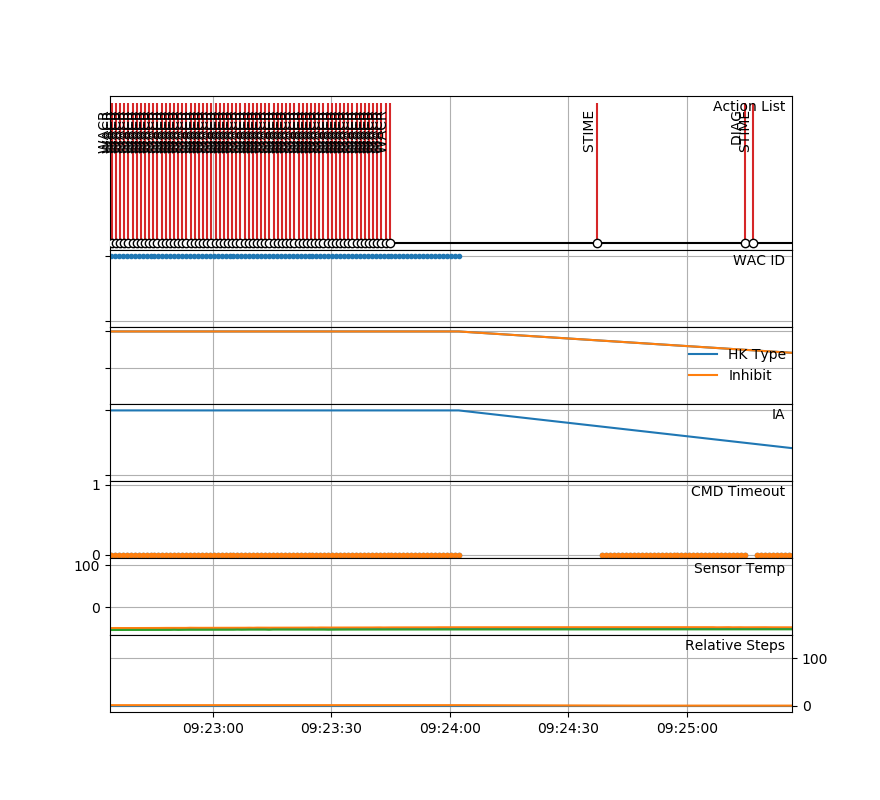

In [17]:
%matplotlib notebook

gs = gridspec.GridSpec(7, 1, height_ratios=[1, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
gs.update(hspace=0.0)
fig = plt.figure(figsize=(8.8, 8), constrained_layout=True)
a0 = fig.add_subplot(gs[0])
a1 = fig.add_subplot(gs[1], sharex=a0)
a2 = fig.add_subplot(gs[2], sharex=a0)
a3 = fig.add_subplot(gs[3], sharex=a0)
a4 = fig.add_subplot(gs[4], sharex=a0)
a5 = fig.add_subplot(gs[5], sharex=a0)
a6 = fig.add_subplot(gs[6], sharex=a0)

# Action List
size = TC.shape[0]
TC['LEVEL'] = 1

markerline, stemline, baseline = a0.stem(TC['DT'], TC['LEVEL'], linefmt='C3-', basefmt="k-", use_line_collection=True)
plt.setp(markerline, mec="k", mfc="w", zorder=3)
markerline.set_ydata(np.zeros(size))
a0.text(.99,.9,'Action List', horizontalalignment='right', transform=a0.transAxes)
a0.grid(True)
for i in range(0, size):
    a0.annotate(TC.ACTION.iloc[i], xy=(TC.DT.iloc[i], TC.LEVEL.iloc[i]), xytext=(0,-2),
            textcoords="offset points", va="top", ha="right", rotation=90)

## WAC ID
a1.plot(WHK['DT'], (WHK[44]&0x07), '.')
a1.text(.99,.8,'WAC ID', horizontalalignment='right', transform=a1.transAxes)
a1.grid(True)
a1.set_ylim([-0.1,1.1])
plt.setp(a1.get_yticklabels(), visible=False)

## Normal HK or EXT
a2.plot(WHK['DT'], (WHK[44]&0x0C).values>2, label='HK Type')
a2.plot(WHK['DT'], (WHK[58]&0x08).values>3, label='Inhibit')
a2.grid(True)
a2.set_ylim([-0.1,1.1])
plt.setp(a2.get_yticklabels(), visible=False)
a2.legend(loc='center right', bbox_to_anchor= (1.0, 0.5), ncol=1, borderaxespad=0, frameon=False)

## Image Acquisition
a3.plot(WHK['DT'], (WHK[58]&0x04).values>3)
a3.text(.99,.8,'IA', horizontalalignment='right', transform=a3.transAxes)
a3.grid(True)
a3.set_ylim([-0.1,1.1])
plt.setp(a3.get_yticklabels(), visible=False)

## WAC CMD Timeout
a4.plot(df['DT'], df[34] == 0x4, '.', label='WACL')
a4.plot(df['DT'], df[35] == 0x4, '.', label='WACR')
a4.text(.99,.8,'CMD Timeout', horizontalalignment='right', transform=a4.transAxes)
a4.grid(True)

## Temperature
RT = ((((WHK[57]&0x7F)*256 + (WHK[58]&0xF0)).values>>4))/8 + (WHK[57]&0x80==0x80)*(-2047/8)
a5.plot(df['DT'], LWAC_T)
a5.plot(df['DT'], RWAC_T)
a5.plot(WHK['DT'], RT)
a5.text(.99,.8,'Sensor Temp', horizontalalignment='right', transform=a5.transAxes)
a5.grid(True)

# Relative Steps
a6.plot(df['DT'], (df[68]*256+df[69]))
a6.plot(df['DT'], (df[70]*256+df[71]))
a6.text(.99,.8,'Relative Steps', horizontalalignment='right', transform=a6.transAxes)
a6.grid(True)
a6.yaxis.tick_right()
a6.yaxis.set_label_position('right')

#remove y axis and spines
a0.get_yaxis().set_visible(False)

#remove x-xis for all but last
plt.setp(a0.get_xticklabels(), visible=False)
plt.setp(a1.get_xticklabels(), visible=False)
plt.setp(a2.get_xticklabels(), visible=False)
plt.setp(a3.get_xticklabels(), visible=False)
plt.setp(a4.get_xticklabels(), visible=False)
plt.setp(a5.get_xticklabels(), visible=False)
        
#Re-adjust x-axis so that 
xlimits = a0.get_xlim()
new_xlimits = (xlimits[0],(xlimits[1] - xlimits[0])*1.3+xlimits[0]);
a0.set_xlim(new_xlimits)

plt.show()